### importation de libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

import os
import seaborn as sns
import cv2

from keras.utils import to_categorical

print(tf.__version__)

2.18.0


### Importation des données
recupération de chemin de données d'entrainement et de test

In [2]:
TRAIN_DIR = r'dataset\train'
IMG_SIZE = 32

Créattion de fonction

In [3]:
#
def get_data(class_name, dir):
    dataSet = []
    
    for name in class_name:
        path = os.path.join(dir, name)
        
        path_img = os.listdir(path)
        label = class_name.index(name)
        
        for img in path_img:
            
            img_array = cv2.imread(os.path.join(path, img))
            new_img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            
            dataSet.append([new_img_array, label])
            
    return dataSet

In [4]:
class_name = ['adenocarcinoma', 'large.cell.carcinoma', 'squamous.cell.carcinoma', 'normal']

In [5]:
def get_X_y(data):
    X, y = [],[]
    
    for variable, label in data :
        X.append(variable)
        y.append(label)
        
    return X, y

In [6]:
data = get_data(class_name, TRAIN_DIR)

X, y = get_X_y(data)

### Analyse exploratoire de données

In [7]:
np.array(X).shape

(613, 32, 32, 3)

La matrice X est un tableau qui contient 613 images, dont chaque image à une taille de 32x32 tridimensionnelle(l'image est colorée)

* Affichage aléatoire de quelque images

In [8]:
def visualiser_images(images, class_name, y_predict, nb_example = 16, nb_row = 4, is_random = True):

    plt.figure(figsize=(15, 15))
    for i in range(nb_example):
        
        index = i
        if(is_random):
            index = np.random.randint(len(X))
            
        img = X[index]

        plt.subplot(nb_row, nb_row, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(class_name[y_predict[index]])

        #plt.title(class_name[y[index]])  
        #plt.imshow(img)

    plt.show()

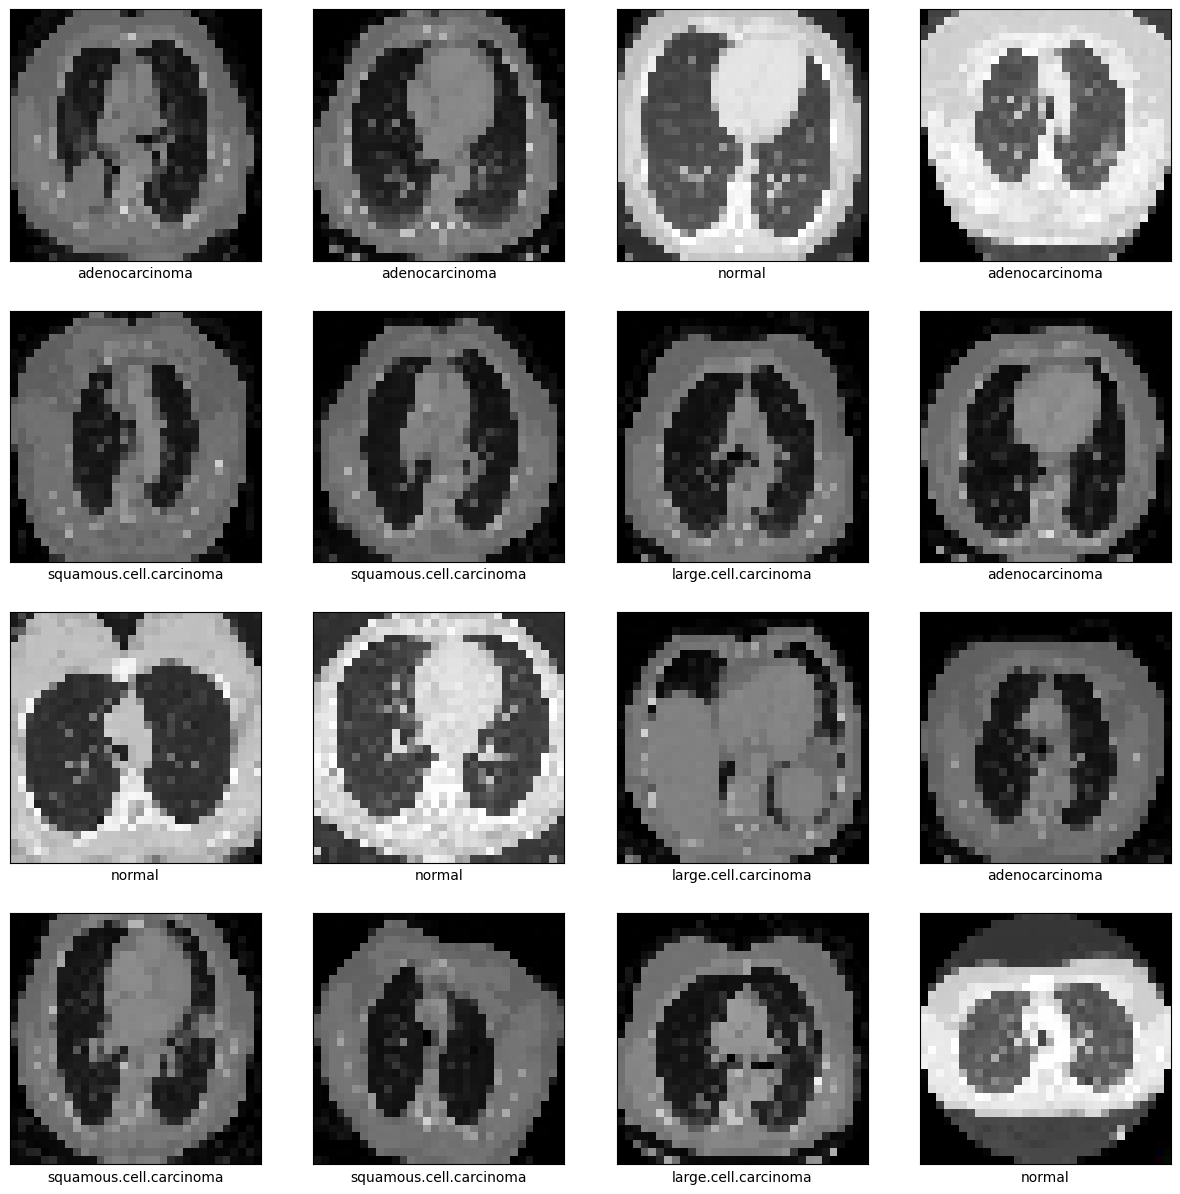

In [9]:
visualiser_images(X, class_name, y)

In [10]:
#data.describe()

(array([195.,   0.,   0., 115.,   0.,   0., 155.,   0.,   0., 148.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

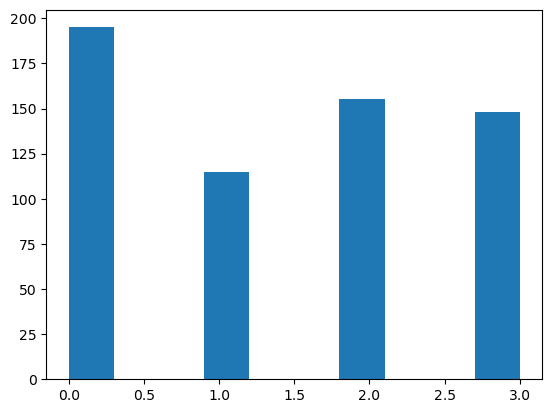

In [11]:
plt.hist(y)

In [12]:
y[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Recupération de données  d'entraînement (training set) et de validation (valid set)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 0)
VALIDATE_DIR = r'dataset\validation'

### Prétraitement

In [14]:
X_train = tf.cast(X_train, tf.float32)
X_train /= 255.0
X_test = tf.cast(X_test, tf.float32)
X_test /= 255.0

In [15]:
y_train = to_categorical(y_train, len(class_name)) # Codification de label

### récuperation de données de validation

In [16]:
data_valid = get_data(class_name, VALIDATE_DIR)
X_valid, y_valid = get_X_y(data_valid)

In [17]:
X_valid = tf.cast(X_valid, tf.float32)
X_valid /= 255.0
y_valid = to_categorical(y_valid, len(class_name)) # Codification de label

In [18]:
X_train.shape

TensorShape([490, 32, 32, 3])

In [19]:
X_test.shape

TensorShape([123, 32, 32, 3])

In [20]:
y_train.shape

(490, 4)

In [21]:
X_valid.shape

TensorShape([72, 32, 32, 3])

### Création du modèle

Construction du Reseau de neurone à convolution

In [22]:
y_train

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [23]:
# Variables
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = len(class_name)

In [24]:
from tensorflow.keras.metrics import Precision, Recall

In [25]:
model = Sequential()

model.add(Conv2D(16, (4,4), input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (4,4), input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (4,4), input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

METRICS = metrics=['accuracy',Precision(name='precision'), Recall(name='recall')]

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = METRICS)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,556 (677.95 KB)

 Trainable params: 173,556 (677.95 KB)

 Non-trainable params: 0 (0.00 B)

## Entrainement du modele

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
early_stop = EarlyStopping(monitor = 'val_loss', verbose=1, patience=25)

In [29]:
BATCH_SIZE = 32
EPOCHS = 100

In [30]:
# Train the model
training_history = model.fit(
                    X_train, 
                    y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_valid, y_valid),
                    verbose=1,
                    callbacks=[early_stop]
                    )

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.2973 - loss: 1.3398 - precision: 0.7217 - recall: 0.0566 - val_accuracy: 0.3194 - val_loss: 1.3626 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.3379 - loss: 1.3022 - precision: 0.6964 - recall: 0.0774 - val_accuracy: 0.3472 - val_loss: 1.3473 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4057 - loss: 1.2329 - precision: 0.7382 - recall: 0.0634 - val_accuracy: 0.4583 - val_loss: 1.1676 - val_precision: 1.0000 - val_recall: 0.1389
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5821 - loss: 1.0067 - precision: 0.7977 - recall: 0.2626 - val_accuracy: 0.3194 - val_loss: 1.0782 - val_precision: 1.0000 - val_recall: 0.1389
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5971 - loss: 0.9608 - precision: 0.7579 - recall: 0.2709 - val_accuracy: 0.41

### Courbe de la fonction d'erreur et de la precision

In [31]:
def plot_learning_curve(history, epoch):
    epoch_range = range(1, epoch + 1)
    
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Précision du modèle')
    plt.ylabel('Model')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left') 
    plt.show()
    
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Perte de modèle')
    plt.ylabel('Model')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')   
    plt.show()

In [32]:
best_epoch = early_stop.stopped_epoch + 1

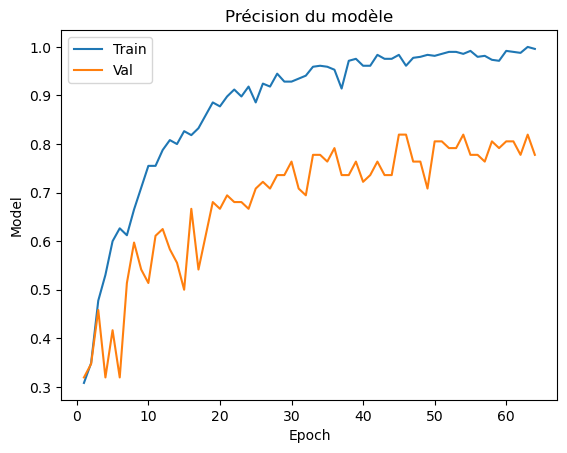

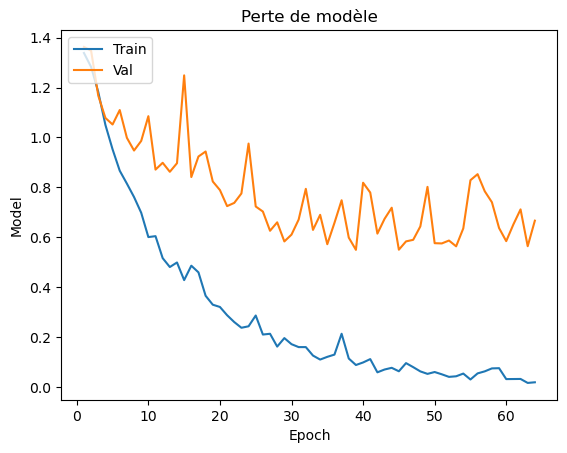

In [33]:
plot_learning_curve(training_history, best_epoch)

In [34]:
score = model.evaluate(X_test, to_categorical(y_test, len(class_name)))

print('\nTest Loss : ', score[0])
print("Accuracy : %.2f%% " % (score[1]*100))
print('Test Precision : ', score[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9239 - loss: 0.6271 - precision: 0.9239 - recall: 0.9239

Test Loss :  0.45473942160606384
Accuracy : 92.68% 
Test Precision :  0.9268292784690857


In [35]:
y_predict = np.argmax(model.predict(X_test), axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


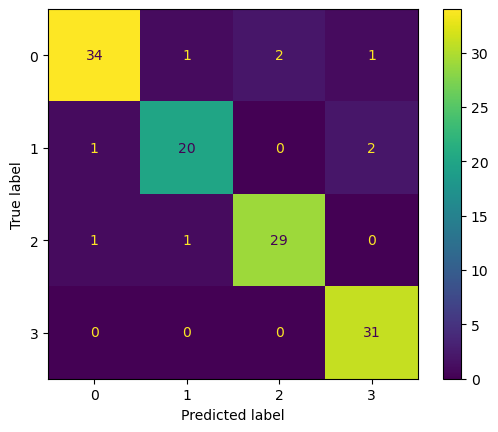

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_predict)

cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.show()

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92        38
           1       0.91      0.87      0.89        23
           2       0.94      0.94      0.94        31
           3       0.91      1.00      0.95        31

    accuracy                           0.93       123
   macro avg       0.93      0.92      0.92       123
weighted avg       0.93      0.93      0.93       123



### Prédiction de nouvel image

In [38]:
def get_X(dir):
    X = []
    
    path = dir
    path_img = os.listdir(path)
    
    for img in path_img:

        img_array = cv2.imread(os.path.join(path, img))
        new_img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

        X.append(new_img_array)
        
    return X

In [39]:
TEST_DIR = r'dataset\test_data'

X_new = get_X(TEST_DIR)

img_new = X_new

In [40]:
X_new = tf.cast(X_new, tf.float32)
X_new /= 255.0

In [41]:
X_new.shape

TensorShape([16, 32, 32, 3])

In [42]:
y_predict = np.argmax(model.predict(X_new),axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [43]:
y_predict.shape

(16,)

In [44]:
y_predict

array([0, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3], dtype=int64)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


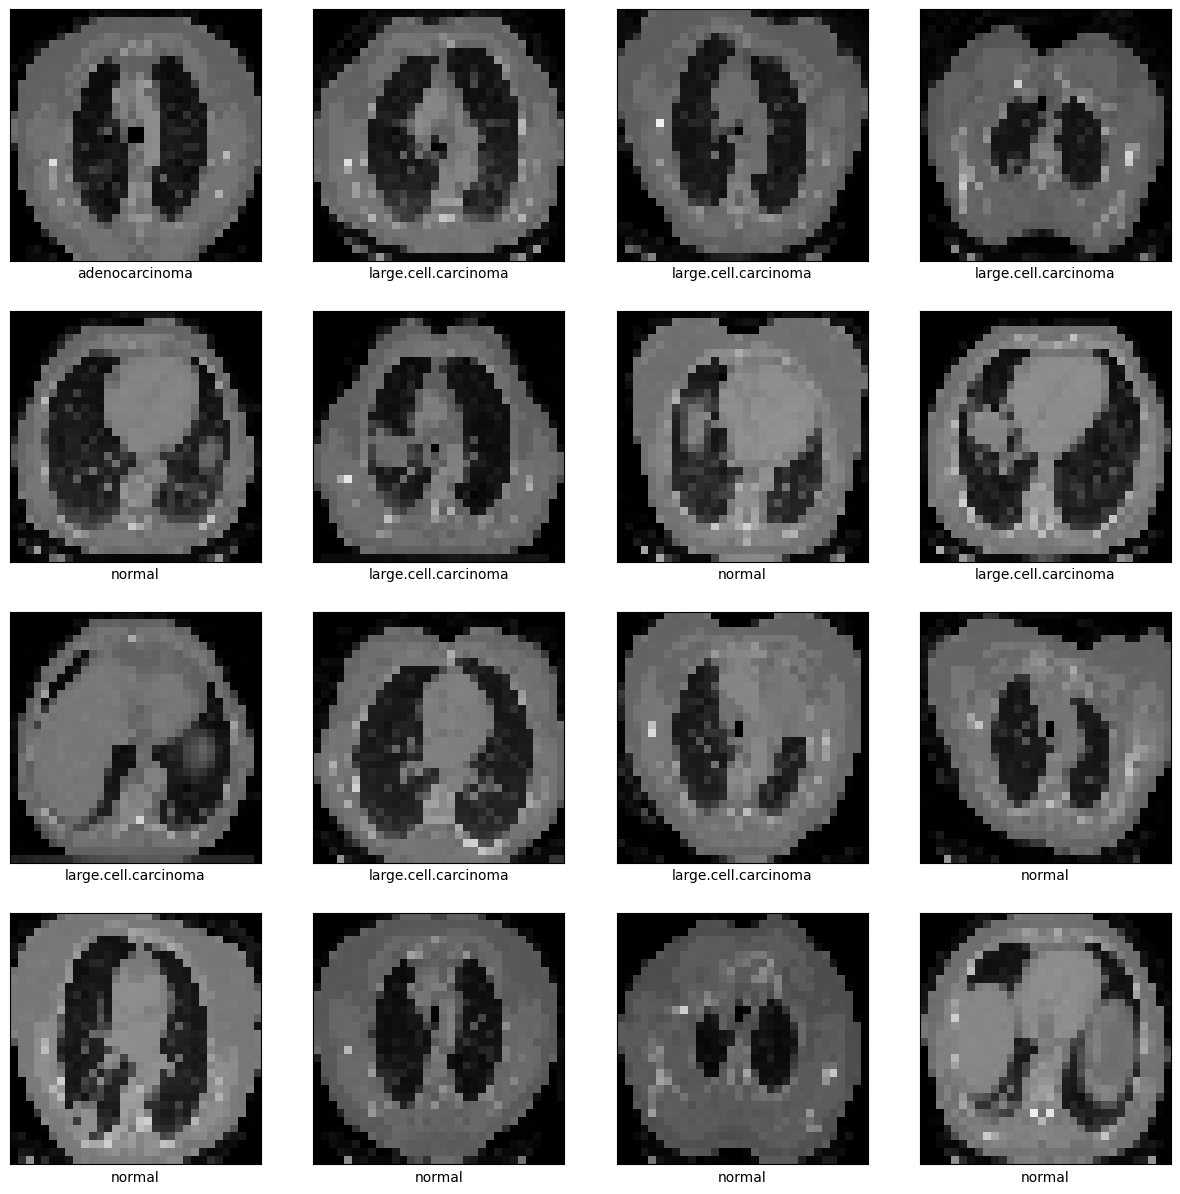

In [45]:
nb_ligne = len(model.predict(X_new))
visualiser_images(img_new, class_name, y_predict, nb_ligne, 4, False)

## Sauverge du model

In [46]:
model.save('cancer_prostate_predicr_CNN.h5')